<a href="https://colab.research.google.com/github/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Dendritic_Branching_Associated_Pathways_GSEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identifying Gene Sets Associated with Dendritic Branching using Gene Set Enrichment Analysis (GSEA)


Neuronal function and connectivity are heavily influenced by the structure and complexity of dendrites, branching extensions that integrate signals from other neurons. Dendritic arborization, the process by which dendrites form and develop, is crucial for the proper function of individual neurons and the brain (McAllister, 2005). Local and cell-wide dendrite patterning are regulated by neuronal activity, with calcium influx mediated by ion channels like NMDA (N-methyl-D-aspartate) receptors and VSCCs (voltage-sensitive calcium channels) (Wong & Ghosh, 2002). Calcium signaling has been shown to regulate local dendrite structure, affecting branch dynamics and stability (Konur & Ghosh, 2005), and activate intracellular signaling proteins, such as CaMKs (calmodulin-dependent protein kinases), which modulate gene expression (Redmond et al., 2002). Still, the molecular mechanisms and underlying dendritic arborization remain to be fully understood, and are critical for understanding neural circuit development and synaptic connectivity, as well as various neurological pathologies.

In this notebook, we will examine the regulation of dendritic morphology through analysis of the transcriptomic and morphological cortical mouse neuron data provided by the Allen Institute (Gouwens et al., 2020). Rather than focusing on the most correlated individual genes, which may not capture the broader effects of biological processes like signaling or metabolic pathways, we adopt a gene set-level approach to capture the coordinated activity of many genes. We will use Gene Set Enrichment Analysis, a statistical method that identifies gene sets correlated with a target phenotype. These gene sets are sets of related genes compiled in various databases that can represent biological processes like pathways or other types of functional relationships. The algorithm involves a number of steps, but the main principle is the use a weighted Kolmogorov-Smirnov-like statistic to calculate an enrichment score (ES) reflecting how correlated a set of genes is with the phenotype overall. More details about this algorithm can be found in the original paper: https://www.pnas.org/doi/10.1073/pnas.0506580102. By applying GSEA to examine gene expression and dendrite morphology, we will identify gene sets linked to calcium signaling, which regulates dendritic arborization through CaMKs and various signaling pathways that mediate dendritic growth.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Data analysis and manipulation
import pandas as pd
import numpy as np

#GSEA
!pip install gseapy
import gseapy as gp
from gseapy.plot import gseaplot
from gseapy.plot import enrichment_map

#Saving and loading results
import pickle

#Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Leading-edge subset analysis
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import binarize

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.2/549.2 kB 7.5 MB/s eta 0:00:00


#Data Preprocessing

Let's begin by loading the transcriptomic/morphological data and neuron metadata as pandas dataframes. By printing the columms, we can see the types of data in the datasets. In this analysis, we will be focusing on the gene expression data and dendrite.num_branches.


In [ ]:
cell_data = pd.read_hdf("/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/genes_morph.hdf5.lz4")
cell_metadata = pd.read_hdf("/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/metadata.hdf5.lz4")
print(cell_data.columns, "\n", cell_metadata.columns)

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'all_neurites.num_tips', 'basal_dendrite.num_tips',
       'dendrite.num_nodes', 'axon.num_nodes', 'all_neurites.num_nodes',
       'basal_dendrite.num_nodes', 'dendrite.num_branches',
       'axon.num_branches', 'all_neurites.num_branches',
       'basal_dendrite.num_branches'],
      dtype='object', length=45792) 
 Index(['project', 'cell_specimen_name', 'hemisphere', 'structure', 'donor_id',
       'donor_name', 'biological_sex', 'age', 'ethnicity',
       'medical_conditions', 'full_genotype', 'dendrite_type',
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
    

##Exploratory Analysis

We can get an overview and summary statistics of the data using `df.describe()`

In [ ]:
cell_data["dendrite.num_branches"].describe()

,dendrite.num_branches
count,573.000000
mean,55.265271
std,22.805949
min,16.000000
25%,39.000000
50%,50.000000
75%,68.000000
max,148.000000


A histogram shows the distribution of the dendrite.num_branches:

<Axes: xlabel='dendrite.num_branches', ylabel='Count'>

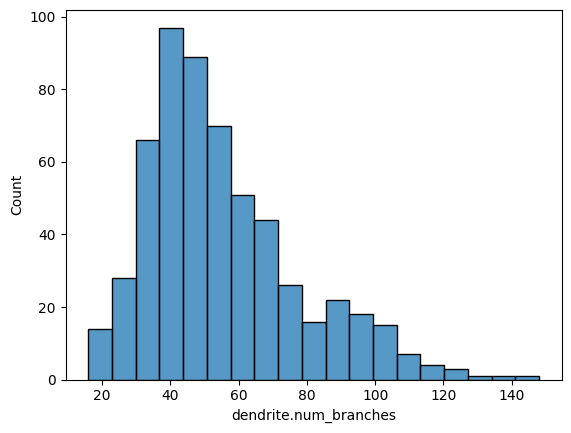

In [ ]:
sns.histplot(cell_data["dendrite.num_branches"])

Next, we should determine if there is NA or missing data using `.isna()` and `.any()`.

In [ ]:
cell_data["dendrite.num_branches"].isna().any()

False

We can see there is no missing data for dendrite.num_branches; however, we should also verify this for the gene expression data, which can be accessed using `cell_data.iloc[:, :-24]`.

In [ ]:
cell_data.iloc[:, :-24].isna().any().any()

False

We should also examine the metadata, specifically neuron_reconstruction_type, to check the morphological data for any anomalies. First we combine `cell_data` and `cell_metadata` to get the metadata for the specific neurons in `cell_data`, as `cell_metadata` includes data for other neurons without morphological reconstructions. Printing the columns shows that the metadata is now included.

In [ ]:
cell_data = cell_data.join(cell_metadata, how="inner")
cell_data.columns

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
      dtype='object', length=45814)

In [ ]:
cell_data["neuron_reconstruction_type"].unique()

array(['full', 'dendrite-only'], dtype=object)

By looking at the different reconstruction types, we can see that some neurons have reconstructions of the dendrites only. Because we are focusing on dendritic morphology, this will not affect the analysis. However, if you intend to analyze an axon feature, you should remove the cells with incomplete reconstructions.

##GSEA Setup: The Ranking Metric and Ranked List of Genes

The first step of GSEA requires a list of all the genes in the dataset ranked by a suitable metric. There are multiple different metrics that can be used depending on the type of data, but the metric should ultimately reflect the correlation between a gene's expression level and the phenotype. GSEA is often applied to datasets with two distinct classes or experimental conditions (e.g. normal cells vs. disease state cells) to identify pathways that are upregulated in one class/condition compared to the other. In that case, a metric incorporating the differential expression of each gene (fold change) between the two classes is used. For this analysis, we are analyzing a continuous phenotype where there are not two distinct classes. Therefore, we will use the Pearson correlation coefficent as our ranking metric instead.

In [ ]:
corrs = cell_data.iloc[:, :-46].corrwith(cell_data["dendrite.num_branches"]) #Computing correlations between each gene with dendritic branching.
corrs = corrs.sort_values(ascending=False) #Ranking the list with the most correlated genes at the top.
corrs.head(7)

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,0
Arpp21,0.512190
Slc17a7,0.508691
Cacna2d1,0.499428
Ptprd,0.491913
R3hdm1,0.487666
Phactr1,0.482130
Nell2,0.480631


In [ ]:
corrs.tail(7)

,0
n-R5s139,NaN
n-R5s141,NaN
n-R5s142,NaN
n-R5s143,NaN
n-R5s144,NaN
n-R5s146,NaN
n-R5s149,NaN


As we can see by printing the tail of `corrs`, some genes have NaN correlation values. This is because these genes are not expressed in any sample in the dataset, and thus there is no spread in the expression data (standard deviation = 0), resulting in an undefined value. These genes will not be relevant for the analysis and can be removed from the ranked list `corrs`.

In [ ]:
corrs = corrs.dropna()
corrs.tail(7)

,0
Ube3a,-0.296282
Dpp6,-0.299590
Rab3b,-0.300480
Elavl2,-0.300543
Grip1,-0.303891
Kcnc2,-0.304194
Gria1,-0.315897


#Gene Set Enrichment Analysis (GSEA)

##Selecting a Gene Set Database and Converting Gene Symbols

Next, we need to select gene set databases to analyze. GSEApy


In [ ]:
gp.get_library_name(organism="Mouse") #Shows all gene set databases in GSEApy package


In [ ]:
from gseapy import Msigdb
msig = Msigdb()
# mouse hallmark gene sets
gmt = msig.get_gmt(category='mh.all', dbver="2024.1.Mm")

In [ ]:

# list categories given dbver.
msig.list_category(dbver="2024.1.Mm") # mouse


['m1.all',
 'm2.all',
 'm2.cgp',
 'm2.cp.biocarta',
 'm2.cp.reactome',
 'm2.cp',
 'm2.cp.wikipathways',
 'm3.all',
 'm3.gtrd',
 'm3.mirdb',
 'm5.all',
 'm5.go.bp',
 'm5.go.cc',
 'm5.go.mf',
 'm5.go',
 'm5.mpt',
 'm8.all',
 'mh.all',
 'msigdb']

In [ ]:
# list msigdb version you wanna query
msig.list_dbver()

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [ ]:
#o make sure our gene symbols are correct for the database(s) we will later input into the GSEA algorithm.

In [ ]:
#geneData.columns = geneData.columns.str.upper() #Making all gene identifiers uppercase for the correct gseapy/enrichr format (NOTE: Only if using the databases attached to gseapy/enrichr, which can be found with this gp.get_library_name(organism="Mouse"))

##Reactome

##KEGG

##Gene Ontology (GO) Biological Process

##GO Molecular Function

##GO Cellular Component

#Visualizations and Graphs

##GSEA Plots

##Network Visualizations

#Leading Edge Subset Analysis

# Works Cited

Aleksander, S., Balhoff, J. P., Carbon, S., J. Michael Cherry, Drabkin, H. J., Ebert, D., Feuermann, M., Gaudet, P., Harris, N. L., Hill, D. P., Lee, R., Mi, H., Sierra, Mungall, C. J., Anushya Muruganujan, Tremayne Mushayahama, Sternberg, P. W., Thomas, P., Van, K. M., & Ramsey, J. (2023). The Gene Ontology Knowledgebase in 2023. Genetics, 224(1). https://doi.org/10.1093/genetics/iyad031

‌Ashburner, M., Ball, C. A., Blake, J. A., Botstein, D., Butler, H., Cherry, J. M., Davis, A. P., Dolinski, K., Dwight, S. S., Eppig, J. T., Harris, M. A., Hill, D. P., Issel-Tarver, L., Kasarskis, A., Lewis, S., Matese, J. C., Richardson, J. E., Ringwald, M., Rubin, G. M., & Sherlock, G. (2000). Gene Ontology: tool for the unification of biology. Nature Genetics, 25(1), 25–29. https://doi.org/10.1038/75556

Chen, H., McCaffery, J. M., & Chan, D. C. (2007). Mitochondrial fusion protects against neurodegeneration in the cerebellum. Cell, 130(3), 548–562. https://doi.org/10.1016/j.cell.2007.06.026

Fang, Z., Liu, X., & Peltz, G. (2022). GSEApy: a comprehensive package for performing gene set enrichment analysis in Python. Bioinformatics, 39(1). https://doi.org/10.1093/bioinformatics/btac757

Feature Extraction — neuron morphology 1.1.7 documentation. (2023). Readthedocs.io. https://neuron-morphology.readthedocs.io/en/latest/feature_extraction.html

Gouwens, N. W., Sorensen, S. A., Baftizadeh, F., Budzillo, A., Lee, B. R., Jarsky, T., Alfiler, L., Baker, K., Barkan, E., Berry, K., Bertagnolli, D., Bickley, K., Bomben, J., Braun, T., Brouner, K., Casper, T., Crichton, K., Daigle, T. L., Dalley, R., & de Frates, R. A. (2020). Integrated Morphoelectric and Transcriptomic Classification of Cortical GABAergic Cells. Cell, 183(4), 935-953.e19. https://doi.org/10.1016/j.cell.2020.09.057

Hagenston, A. M., & Bading, H. (2011). Calcium Signaling in Synapse-to-Nucleus Communication. Cold Spring Harbor Perspectives in Biology, 3(11), a004564–a004564. https://doi.org/10.1101/cshperspect.a004564

Ishihara, N., Nomura, M., Jofuku, A., Kato, H., Suzuki, S. O., Masuda, K., Otera, H., Nakanishi, Y., Nonaka, I., Goto, Y., Taguchi, N., Morinaga, H., Maeda, M., Takayanagi, R., Yokota, S., & Mihara, K. (2009). Mitochondrial fission factor Drp1 is essential for embryonic development and synapse formation in mice. Nature Cell Biology, 11(8), 958–966. https://doi.org/10.1038/ncb1907

‌Kanehisa, M., & Goto, S. (2000). KEGG: Kyoto Encyclopedia of Genes and Genomes. Nucleic Acids Research, 28(1), 27–30. https://doi.org/10.1093/nar/28.1.27

Kimura, T., & Murakami, F. (2014). Evidence That Dendritic Mitochondria Negatively Regulate Dendritic Branching in Pyramidal Neurons in the Neocortex. Journal of Neuroscience, 34(20), 6938–6951. https://doi.org/10.1523/jneurosci.5095-13.2014

Konur, S., & Ghosh, A. (2005). Calcium Signaling and the Control of Dendritic Development. Neuron, 46(3), 401–405. https://doi.org/10.1016/j.neuron.2005.04.022

Kulkarni, V. A., & Firestein, B. L. (2012). The dendritic tree and brain disorders. Molecular and Cellular Neuroscience, 50(1), 10–20. https://doi.org/10.1016/j.mcn.2012.03.005

Li, Z., Okamoto, K.-I., Hayashi, Y., & Sheng, M. (2004). The Importance of Dendritic Mitochondria in the Morphogenesis and Plasticity of Spines and Synapses. Cell, 119(6), 873–887. https://doi.org/10.1016/j.cell.2004.11.003

McAllister, A. K. (2000). Cellular and Molecular Mechanisms of Dendrite Growth. Cerebral Cortex, 10(10), 963–973. https://doi.org/10.1093/cercor/10.10.963

M Orlic-Milacic, Beavers, D., Conley, P., Gong, C., Gillespie, M., Griss, J., Haw, R., Jassal, B., Matthews, L., May, B., Petryszak, R., Eliot Ragueneau, Rothfels, K., Sevilla, C., Shamovsky, V., Stephan, R., Krishna Kumar Tiwari, Thawfeek Varusai, Weiser, J., & Wright, A. (2023). The Reactome Pathway Knowledgebase 2024. Nucleic Acids Research, 52(D1). https://doi.org/10.1093/nar/gkad1025

Redmond, L., Kashani, A. H., & Ghosh, A. (2002). Calcium Regulation of Dendritic Growth via CaM Kinase IV and CREB-Mediated Transcription. Neuron, 34(6), 999–1010. https://doi.org/10.1016/s0896-6273(02)00737-7

Sokal, R., & Michener, C. (1958). A Statistical Method for Evaluating Systematic Relationships. University of Kansas Science Bulletin. https://ia800703.us.archive.org/5/items/cbarchive_33927_astatisticalmethodforevaluatin1902/astatisticalmethodforevaluatin1902.pdf

Subramanian, A., Tamayo, P., Mootha, V. K., Mukherjee, S., Ebert, B. L., Gillette, M. A., Paulovich, A., Pomeroy, S. L., Golub, T. R., Lander, E. S., & Mesirov, J. P. (2005). Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences, 102(43), 15545–15550. https://doi.org/10.1073/pnas.0506580102

‌Wong, R. O. L., & Ghosh, A. (2002). Activity-dependent regulation of dendritic growth and patterning. Nature Reviews Neuroscience, 3(10), 803–812. https://doi.org/10.1038/nrn941‌

Wu, G.-Y. ., Deisseroth, K., & Tsien, R. W. (2001). Activity-dependent CREB phosphorylation: Convergence of a fast, sensitive calmodulin kinase pathway and a slow, less sensitive mitogen-activated protein kinase pathway. Proceedings of the National Academy of Sciences, 98(5), 2808–2813. https://doi.org/10.1073/pnas.051634198

‌Wu, T., Hu, E., Xu, S., Chen, M., Guo, P., Dai, Z., Feng, T., Zhou, L., Tang, W., Zhan, L., Fu, X., Liu, S., Bo, X., & Yu, G. (2021). clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation, 2(3), 100141. https://doi.org/10.1016/j.xinn.2021.100141
